# Segment Anything in Medical Images

Segmentation is a fundamental task in medical imaging analysis. Deep learning-based models have shown great promise in medical image segmentation due to their ability to learn intricate image features and deliver accurate segmentation results across a diverse range of tasks. Recently, the Segmentation Anything Model (SAM) has shown remarkable versatility and performance in natural image segmentation. However, their application to medical image segmentation has been challenging due to the substantial domain gap. In this tutorial, we will introduce how to adapt the SAM's success to medical image segmentation.

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.1.2
CUDA is available: True


An example of MedSAM, as presented by the creators

2024-04-26 11:40:54.836664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 11:40:54.836774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 11:40:54.988384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

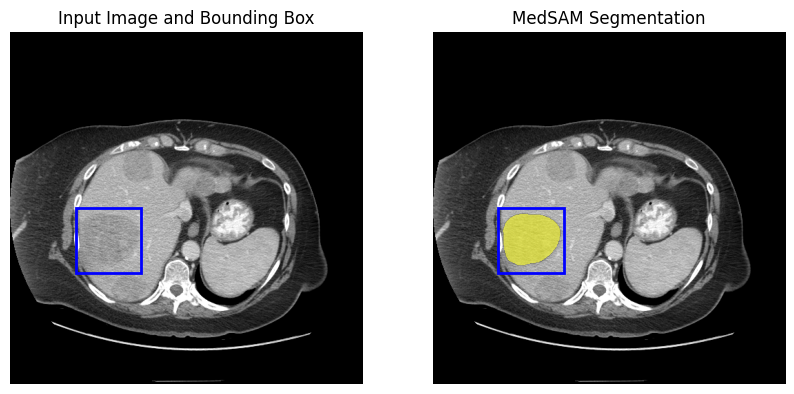

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SamModel, SamProcessor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

img_url = "https://huggingface.co/flaviagiammarino/medsam-vit-base/resolve/main/scripts/input.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_boxes = [95., 255., 190., 350.]

inputs = processor(raw_image, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
outputs = model(**inputs, multimask_output=False)
probs = processor.image_processor.post_process_masks(outputs.pred_masks.sigmoid(), inputs["original_sizes"], inputs["reshaped_input_sizes"], binarize=False)

def show_mask(mask, ax, random_color):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.array(raw_image))
show_box(input_boxes, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[0].axis("off")
ax[1].imshow(np.array(raw_image))
show_mask(mask=probs[0].detach().cpu().numpy() > 0.5, ax=ax[1], random_color=False)
show_box(input_boxes, ax[1])
ax[1].set_title("MedSAM Segmentation")
ax[1].axis("off")
plt.show()


In [3]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  #x_min = max(0, x_min - np.random.randint(0, 20))
  #x_max = min(W, x_max + np.random.randint(0, 20))
  #y_min = max(0, y_min - np.random.randint(0, 20))
  #y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [4]:
ground_truth = Image.open("/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/mask_covid_100.png")
get_bounding_box(np.array(ground_truth))

[30, 26, 174, 130]

Example on an X-ray of the dataset

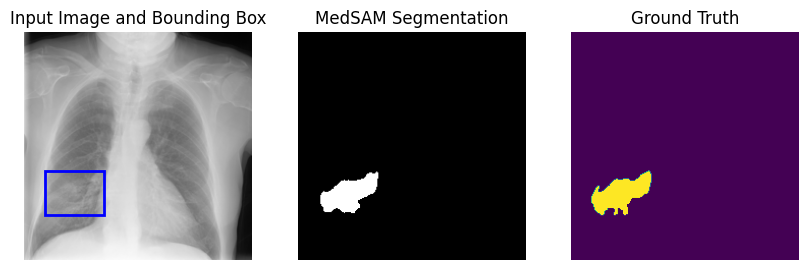

In [10]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SamModel, SamProcessor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

img_url = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/covid_1007.png"
raw_image = Image.open(img_url).convert("RGB")

ground_truth = Image.open("/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/mask_covid_1007.png")

input_boxes = get_bounding_box(np.array(ground_truth))

inputs = processor(raw_image, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
outputs = model(**inputs, multimask_output=False)
probs = processor.image_processor.post_process_masks(outputs.pred_masks.sigmoid(), inputs["original_sizes"], inputs["reshaped_input_sizes"], binarize=False)

def show_mask(mask, ax, random_color):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255, 255, 255])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(np.array(raw_image))
show_box(input_boxes, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[0].axis("off")
ax[1].imshow(np.array(raw_image))
show_mask(mask=probs[0].detach().cpu().numpy() > 0.5, ax=ax[1], random_color=False)
ax[1].set_title("MedSAM Segmentation")
ax[1].axis("off")

ax[2].imshow(np.array(ground_truth))
ax[2].set_title("Ground Truth")
ax[2].axis("off")

plt.show()


In [9]:
gt_mask = np.array(ground_truth).astype(bool)
predicted_mask = np.array(probs[0].detach().cpu().numpy() > 0.5)[0,0,:,:].astype(bool)
# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask, predicted_mask)
union = np.logical_or(gt_mask, predicted_mask)
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.9335951884129128


Inference on the whole set

In [10]:
images_dir = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images"
images = []
for fname in os.listdir(images_dir):
    images.append(str(os.path.join(images_dir, fname)))

masks_dir = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths"
ground_truths = []
for fname in os.listdir(masks_dir):
    ground_truths.append(str(os.path.join(masks_dir, fname)))

ground_truths = np.asarray(ground_truths) 

In [11]:
from tqdm import tqdm
device = "cuda"
iou_list = []
for i in tqdm(range(len(images))):    
    image = Image.open(images[i]).convert("RGB")
    ground_truth = Image.open(ground_truths[i])
    input_boxes = get_bounding_box(np.array(ground_truth))
    inputs = processor(image, input_boxes=[[input_boxes]], return_tensors="pt").to(device)
    outputs = model(**inputs, multimask_output=False)
    probs = processor.image_processor.post_process_masks(outputs.pred_masks.sigmoid(), inputs["original_sizes"], inputs["reshaped_input_sizes"], binarize=False)
    gt_mask = np.array(ground_truth).astype(bool)
    predicted_mask = np.array(probs[0].detach().cpu().numpy() > 0.5)[0,0,:,:].astype(bool)
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(gt_mask, predicted_mask)
    union = np.logical_or(gt_mask, predicted_mask)
    iou = np.sum(intersection) / np.sum(union)
    iou_list.append(iou)

100%|██████████| 7145/7145 [36:04<00:00,  3.30it/s]


In [7]:
print(np.mean(iou_list))

0.8439024390243902
